In [ ]:
%%capture
import os
!pip install kaggle
!rm -rf "sample_data"

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 73 bytes


# Загрузка данных

In [ ]:
!kaggle competitions download -c "dogs-vs-cats-redux-kernels-edition"

 99% 809M/814M [00:03<00:00, 174MB/s]
100% 814M/814M [00:03<00:00, 252MB/s]


In [ ]:
%%capture
!unzip dogs-vs-cats-redux-kernels-edition.zip

In [ ]:
%%capture
# Создаю папку для разархивации обучающей части датасета
unzip_dir = "/content/working/"
os.mkdir(unzip_dir)

# Разархивирую обучающую часть
!unzip train.zip -d "/content/working/"

# Прописываю пути для дальнейшей обработки данных в переменные
working_dir = "/content/working/train/"
base_dir = "/content/working/cat_dog/"

# Создаю директорию для будущего распределения обучащей и валидационной частей общей обучающей выборки
os.mkdir(base_dir)

Удаление ненужных файлов

In [ ]:
!rm -rf "/content/train.zip"
!rm -rf "/content/dogs-vs-cats-redux-kernels-edition.zip"

# Небольшая визуализация датасета
Для первичной оценки данных.

In [ ]:
import matplotlib.pyplot as plt
from math import sqrt

def vis_image(folder="", n_images=9, name_conv="", file_ext=""):
  """
  Функция, максимально старающаяся генерализовать отображение изображений из датасета на одном графике.
  Параметры:
  folder - str, путь, по которому находятся изображения для визуализации
  n_images - int, количество изображений для визуализации
  name_conv - str, часть имени файла, идентифицируемая из датасета
  file_ext - str, расширения файла датасета
  Для работы данной функции необходимо, чтобы изображения имели названия вида: имя_изображения.{индекс}.расширение
  Функцию легко модифицировать под другие названия изображений
  Выход:
  Функция визуализирует изображения, находящиеся в папке, на одном графике по заданным параметрам
  """
  # Устанавливаю размер общего полотна для построения графиков
  plt.rcParams["figure.figsize"] = (n_images, n_images)
  
  # Рассчитываю параметры для подграфиков
  row = int(n_images/2)
  col = int(sqrt(n_images))    
  
  # Визуализирую заданное количество изображений
  for i in range(n_images):
    plt.subplot(row, col, i+1)                                    # Сетка подграфиков, индекс каждого изображения в этой сетке
    filename = f"{folder}{name_conv}.{str(i)}.{file_ext}"         # Генерация пути для каждого файла изображения
    plt.title(f"{name_conv}.{str(i)}.{file_ext}")                 # Отмечаю на подграфике, какое изображение визуализировано
    plt.axis('off')                                               # Убираю информацию об осях для чистоты визуализации
    image = plt.imread(filename)                                  # Записываю каждое изображение в переменную
    plt.imshow(image)                                             # Визуализирую изображение
  
  plt.show()                                                      # Отображаю график с подграфиками

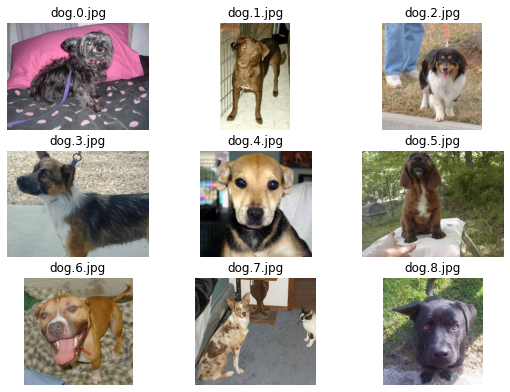

In [ ]:
vis_image(working_dir, 9, "dog", "jpg")

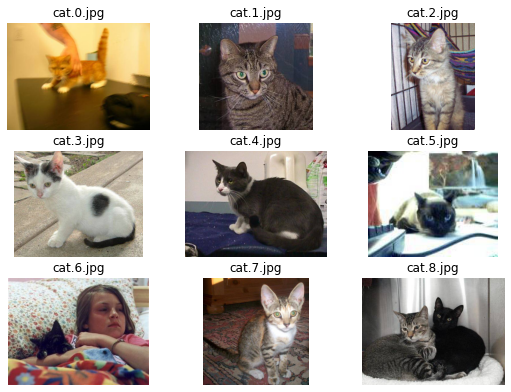

In [ ]:
vis_image(working_dir, 9, "cat", "jpg")

Из данной визуализации очевидно, что в наборе данных содержатся изображения разной ширины и высоты, соответственно, им потребуется предобработка.

# Предобработка датасета

Одним из методов предобработки мог бы стать метод полной предобработки (изменение размера к унифицированному и разметка) в памяти машины и дальнейшее использование измененных размеченных изображений как вход в модель. Однако, бесплатная версия Colab не даёт достаточно памяти, чтобы сделать это в данном случае.

Второй способ - использование класса ```ImageDataGenerator``` и программного интерфейса ```flow_from_directory()``` из библиотеки keras.

API ```flow_from_directory()``` хорошо работает, когда данные разделены на обучающую и тестовую выборку, и, внутри каждой выборки, распределены по классам вида:

      
      train
      |___ cats
      |___ dogs


Необходимо так же разделить обучающие данные на данные для обучения и данные для валидации.

In [ ]:
# Создаю папку для обучающей подвыборки
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

# Создаю папку для валидационной подвыборки
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

# В эти папки будут складыватсья изображения из распакованного архива train, скачанного с kaggle

In [ ]:
# Создаю в папке для обучающей выборки подпапки для разных классов изображений
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# Создаю в папке для валидационной выборки подпапки для разных классов изображений
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

Пришло время разделить данные на обучающие и валидационные, соблюдая классификацию. Разделение всегда будет происходить одинаковым образом, так как оно производится по индексам. 75% данных пойдет в обучение, 25% на валидацию.

In [ ]:
from shutil import copyfile

# Первые 10000 изображений с котиками отправятся в обучающую подвыборку котиков
fnames = [f'cat.{i}.jpg' for i in range(10000)]
for fname in fnames:
    src = os.path.join(working_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    copyfile(src, dst)

# Оставшиеся 2500 изображений котиков отправятся в валидационную подвыборку котиков
fnames = [f'cat.{i}.jpg' for i in range(10000, 12500)]
for fname in fnames:
    src = os.path.join(working_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    copyfile(src, dst)
    
# Первые 10000 изображений с пёселями отправятся в обучающую подвыборку пёселей
fnames = [f'dog.{i}.jpg' for i in range(10000)]
for fname in fnames:
    src = os.path.join(working_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    copyfile(src, dst)

# Оставшиеся 2500 изображений пёселей отправятся в валидационную подвыборку пёселей   
fnames = [f'dog.{i}.jpg' for i in range(10000, 12500)]
for fname in fnames:
    src = os.path.join(working_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    copyfile(src, dst)

Проверка, сколько изображений содержится в каждой папке обучения\валидации

In [ ]:
print('Общее количество котиков для обучения: ', len(os.listdir(train_cats_dir)))
print('Общее количество пёселей для обучения: ', len(os.listdir(train_dogs_dir)))
print('Общее количество котиков для валидации: ', len(os.listdir(validation_cats_dir)))
print('Общее количество пёселей для валидации: ', len(os.listdir(validation_dogs_dir)))

Общее количество котиков для обучения:  10000
Общее количество пёселей для обучения:  10000
Общее количество котиков для валидации:  2500
Общее количество пёселей для валидации:  2500


Наконец, приступаю к предобработке изображений при помощи генераторов keras

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Сначала прописываю, что изображения параметра [255, 255, 255] будут скалироваться к [1/255, 1/255, 1/255]
# с целью ускорения обучения модели.
train_datagen = ImageDataGenerator(
                                      rescale=1./255,
                                   )

validation_datagen = ImageDataGenerator(rescale=1./255)

# Как уже обсуждалось ранее, API flow_from_directory() создан для работы с папками, в которых изображения не только
# разобраны на обучающую и валидационную выборки, но и разложены по классам, что видно из параметров
train_generator = train_datagen.flow_from_directory(
        train_dir,                                        # Папка с данными для обучения
        target_size=(150, 150),                           # Привожу результирующую картинку к размеру 150*150
        batch_size=100,                                   # Обрабатываю исходные данные партиями по 100
        class_mode='binary')                              # В папке с данными для обучения содержатся два класса изображений

# Тот же самый интерфейс используется для данных для валидации, только размер партии равен 50
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=50,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


По выводу, очевидно, что в папке для обучения содержится 20000 изображений 2х классов, а в папке для валидации 5000 изображений 2х классов, что соответствует предварительной подготовке данных.

# Базовая CNN модель
Без transfer learning

In [ ]:
from tensorflow import keras
from keras import layers
from keras.models import Sequential

from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image

from tensorflow.keras.applications import VGG16

Сборка модели

In [ ]:
model = Sequential()
# Блок 1
model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(150, 150, 3)))     # Свёртка на 32 нейрона, окно 3*3, с сохранением размеров входа, 
                                                                                                      # с шагом (1, 1) и функцией активации relu
model.add(layers.MaxPooling2D(2, 2))                                                                  # Пулинг по максимальному значению в окне 2*2

# Блок 2
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))                                # Свёртка на 64 нейрона, окно 3*3, с сохранением размеров входа, 
                                                                                                      # с шагом (1, 1) и функцией активации relu
model.add(layers.MaxPooling2D(2,2))                                                                   # Пулинг по максимальному значению в окне 2*2

# Блок 3
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))                               # Свёртка на 128 нейронов, окно 3*3, с сохранением размеров входа, 
                                                                                                      # с шагом (1, 1) и функцией активации relu
model.add(layers.MaxPooling2D(2,2))                                                                   # Пулинг по максимальному значению в окне 2*2

# "Выпрямляю" выход для подачи в полносвязный слой
model.add(layers.Flatten())

# Блок 4
model.add(layers.Dense(512, activation='relu'))                                                       # Полносвязный слой на 512 нейронов, активация relu
model.add(layers.Dense(1, activation='sigmoid'))                                                      # Полносвязный слой для бинарной классификации, активация sigmoid

model.compile(loss='binary_crossentropy',
            optimizer=RMSprop(learning_rate=0.0001),
            metrics=['accuracy'])

In [ ]:
# Суммарная статистика по слоям и параметрам модели
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 128)      0

Функция для построения графиков метрики качества и функции потерь на обучающей и валидационной выборках

In [ ]:
def plot_loss_accuracy(history):
  """
  Функция строит графики изменения по эпохам метрики качества модели и функции потерь на обучающей и валидационной выборках.
  Параметры:
    функция принимает переменную, в которой хранится результат обучения модели
  """
  plt.rcParams["figure.figsize"] = (8, 4)
  # Записываю метрики качества и функции потерь по обучающей и валидационной выборкам в соответствующие переменные
  acc = history.history['accuracy']                                     # Точность на обучающей выборке
  val_acc = history.history['val_accuracy']                             # Точность на валидационной выборке
  loss = history.history['loss']                                        # Функция потерь на обучающей выборке
  val_loss = history.history['val_loss']                                # Функция потерь на валидационной выборке

  epochs = range(len(acc))                                              # Количество эпох = число вхождений по любому из показателей

  # График точности по эпохам
  plt.plot(epochs, acc, 'bo', label='Точность обучающая')        
  plt.plot(epochs, val_acc, 'b', label='Точность валидационная')
  plt.title('Точность на обучающей и валидационной выборках')
  plt.legend()
  plt.figure()

  # График функции потерь по эпохам
  plt.plot(epochs, loss, 'bo', label='Потери обучающие')
  plt.plot(epochs, val_loss, 'b', label='Потери валидационные')
  plt.title('Функция потерь на обучающей и валидационной выборках')
  plt.legend()

  plt.show()

Обучение модели

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=200,                                      # Из расчета на 20000 обучающих изображений: batch_size (100) * steps (200)
      epochs=15,
      validation_data=validation_generator,
      validation_steps=100                                      # Из расчета на 5000 валидационных изображений: batch_size (50) * steps (100)
)

Epoch 1/15
200/200 [==============================] - 86s 363ms/step - loss: 0.6350 - accuracy: 0.6348 - val_loss: 0.5536 - val_accuracy: 0.7308
Epoch 2/15
200/200 [==============================] - 70s 347ms/step - loss: 0.5469 - accuracy: 0.7247 - val_loss: 0.5377 - val_accuracy: 0.7230
Epoch 3/15
200/200 [==============================] - 69s 346ms/step - loss: 0.5064 - accuracy: 0.7543 - val_loss: 0.5066 - val_accuracy: 0.7446
Epoch 4/15
200/200 [==============================] - 69s 346ms/step - loss: 0.4721 - accuracy: 0.7747 - val_loss: 0.5176 - val_accuracy: 0.7416
Epoch 5/15
200/200 [==============================] - 70s 348ms/step - loss: 0.4455 - accuracy: 0.7920 - val_loss: 0.4731 - val_accuracy: 0.7684
Epoch 6/15
200/200 [==============================] - 69s 346ms/step - loss: 0.4186 - accuracy: 0.8105 - val_loss: 0.4729 - val_accuracy: 0.7768
Epoch 7/15
200/200 [==============================] - 69s 344ms/step - loss: 0.3983 - accuracy: 0.8224 - val_loss: 0.4544 - val_ac

График обучения модели

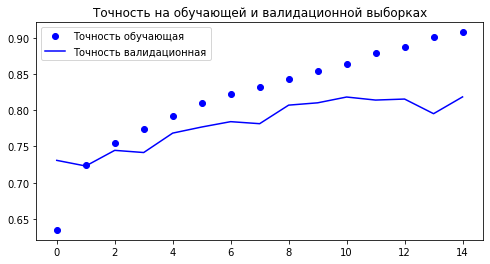

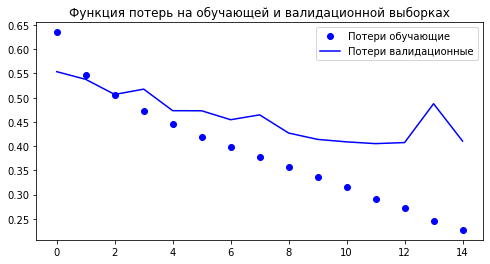

In [ ]:
plot_loss_accuracy(history)

Итак, результат работы базовой (весьма простой) модели: точность на валидационной выборке гуляет в районе 81% и присутсвует ярко выраженное переобучение.

In [ ]:
model.save('cats-dogs-base.hdf5')

# Transfer learning модель, VGG16

Существуют две стратегии использования переноса обучения:

- **Выделение признаков**, в этом случае предобученная модель используется целиком, за исключением последнего полносвязного слоя.
- **Тонкая настройка**, в этом случае верхние слои предобученной модели заново обучаются на новом датасете, который необходимо классифицировать.

**Метод выделения признаков (Feature extraction)**

In [ ]:
# В качестве предобученной модели использую VGG16 с весами, полученными на обучении на датасете imagenet
base_model_tl = VGG16(weights='imagenet',
                           include_top=False,                       # Исключаю полносвязный слой
                           input_shape=(150, 150, 3))               # Параметры изображений из моего датасета

In [ ]:
# Необходимо убедиться, что модель инициализировалась корректно
base_model_tl.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

Настроим предобученную модель на работу с текущим датасетом

In [ ]:
model_feature = Sequential()

model_feature.add(base_model_tl)                                      # Модель VGG16 используется полностью, кроме полносвязного слоя для классификации
model_feature.add(layers.Flatten())                                   # Использую те же самые параметры у последних слоев, что и в прошлой базовой модели
model_feature.add(layers.Dense(512, activation='relu'))
model_feature.add(layers.Dense(1, activation='sigmoid'))

model_feature.compile(loss='binary_crossentropy',
            optimizer=RMSprop(learning_rate=0.00001),
            metrics=['accuracy'])

In [ ]:
# Структура модели, созданной по принципу feature extraction
model_feature.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               4194816   
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 18,910,017
Trainable params: 18,910,017
Non-trainable params: 0
_________________________________________________________________


Необходимо заморозить веса у предобученной модели, чтобы они не переобучались на текущем датасете

In [ ]:
base_model_tl.trainable = False

In [ ]:
# Сравнение количества обучаемых параметров после заморозки весов в модели VGG16
model_feature.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               4194816   
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________


Обучение модели

In [ ]:
history = model_feature.fit(
      train_generator,
      steps_per_epoch=200, 
      epochs=5,
      validation_data=validation_generator,
      validation_steps=100 
)

Epoch 1/5
200/200 [==============================] - 167s 825ms/step - loss: 0.1895 - accuracy: 0.9193 - val_loss: 0.1203 - val_accuracy: 0.9496
Epoch 2/5
200/200 [==============================] - 164s 820ms/step - loss: 0.0878 - accuracy: 0.9651 - val_loss: 0.1010 - val_accuracy: 0.9576
Epoch 3/5
200/200 [==============================] - 163s 817ms/step - loss: 0.0537 - accuracy: 0.9810 - val_loss: 0.0798 - val_accuracy: 0.9684
Epoch 4/5
200/200 [==============================] - 163s 815ms/step - loss: 0.0346 - accuracy: 0.9880 - val_loss: 0.0981 - val_accuracy: 0.9628
Epoch 5/5
200/200 [==============================] - 163s 814ms/step - loss: 0.0211 - accuracy: 0.9930 - val_loss: 0.0856 - val_accuracy: 0.9696


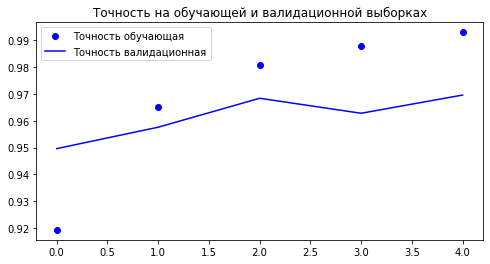

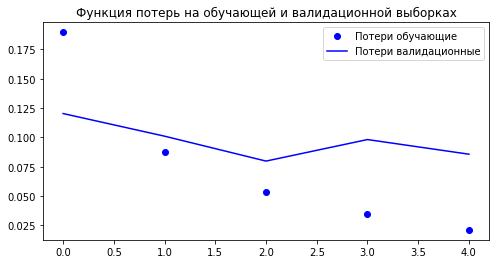

In [ ]:
plot_loss_accuracy(history)

В целом, значительно лучшие результаты по точности и функции потерь: 97% и 0.09, соответственно.

In [ ]:
model_feature.save('cats-dogs-vgg16_full.hdf5')

# Работа с подвыборкой test и подготовка данных для отправки в kaggle

In [ ]:
%%capture
# Путь для тестовых изображений
test_dir = "/content/working/test/"

# Создаю директорию для хранения разархивированных тестовых изображений
os.mkdir(test_dir)

# Разархивирую test.zip
!unzip test.zip -d "/content/working/test/"


In [ ]:
# Удаляю zip архив
!rm -rf "/content/test.zip"

In [ ]:
gen = ImageDataGenerator()
test_batches = gen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=1,
                                       shuffle=False, class_mode=None)

Found 12500 images belonging to 1 classes.


In [ ]:
# Получаю названия файлов в порядке, в котором они поступали в генератор
filenames = test_batches.filenames
# Количество наблюдений в проверочном датасете
nb_samples = len(filenames)

# Список для хранения численной части названия файла в проверочном датасете, соответствует id в целевом предсказании
im_ids = []
# Наполняю список целыми числами, соответствующими названиям файлов
for i in range(nb_samples):
  im_id = int(filenames[i].split('.')[0][5:])
  im_ids.append(im_id)

# Должно быть равно количеству файлов в папке test
print(len(im_ids))

12500


In [ ]:
# генерирую предсказания для базовой модели и для модели vgg16
y_test_base = model.predict_generator(test_batches, nb_samples)
y_test_vgg_full = model_feature.predict_generator(test_batches, nb_samples)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Небольшая хитрость для уменьшения пенальти за ошибочную классификацию kaggle
y_test_base_clipped = y_test_base.clip(min=0.05, max=0.95)
y_test_vgg_full_clipped = y_test_vgg_full.clip(min=0.05, max=0.95)

In [ ]:
y_test_base_clipped = y_test_base_clipped.flatten()

y_test_base_clipped = y_test_base_clipped.tolist()

print(type(y_test_base_clipped))

<class 'list'>


In [ ]:
y_test_vgg_full_clipped = y_test_vgg_full_clipped.flatten()

y_test_vgg_full_clipped = y_test_vgg_full_clipped.tolist()

print(type(y_test_vgg_full_clipped))

<class 'list'>


In [ ]:
model_base_preds = list(zip(im_ids, y_test_base_clipped))
model_feature_preds = list(zip(im_ids, y_test_vgg_full_clipped))

In [ ]:
model_base_df = pd.DataFrame(model_base_preds, columns=['id', 'label'])
model_feature_df = pd.DataFrame(model_feature_preds, columns=['id', 'label'])

In [ ]:
model_base_df.head()

,id,label
0,1,0.05
1,10,0.05
2,100,0.95
3,1000,0.95
4,10000,0.95


In [ ]:
model_feature_df.head()

,id,label
0,1,0.95
1,10,0.05
2,100,0.05
3,1000,0.95
4,10000,0.95


In [ ]:
import pandas as pd
sample_df = pd.read_csv("/content/sample_submission.csv")

In [ ]:
sample_df.head()

,id,label
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5


In [ ]:
subm_df_base = sample_df.merge(model_base_df, on='id')

In [ ]:
subm_df_base.drop('label_x', axis=1, inplace=True)

In [ ]:
subm_df_base.rename(columns = {'label_y':'label'}, inplace = True)

In [ ]:
subm_df_base.to_csv("subm_df_base_clipped.csv", index=False)

In [ ]:
subm_df_vgg = sample_df.merge(model_feature_df, on='id')
subm_df_vgg.drop('label_x', axis=1, inplace=True)
subm_df_vgg.rename(columns = {'label_y':'label'}, inplace = True)
subm_df_vgg.to_csv("subm_df_vgg_clipped.csv", index=False)

# Результаты

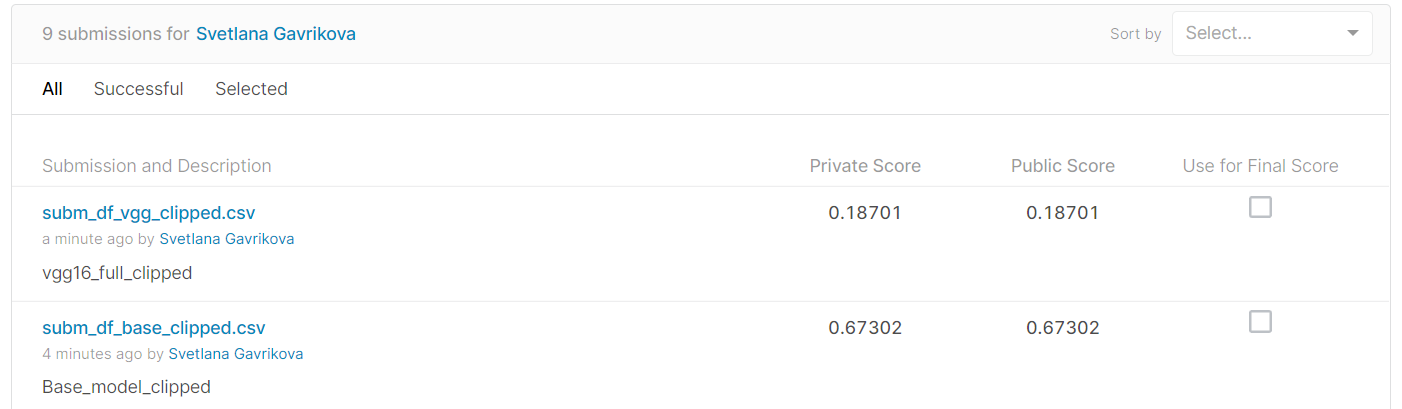